# TRAIN A LOGISTIC REGRESSION

In this notebook, we will implement and train a logistic regression, as a 1-layer neural network.

---

**IMPORTANT**: for all the neural networks we will implement, **we will go through the same 12 steps**:

- load the dataset (**load_data**)

- visualize it (**visualize_data**)
- preprocess the dataset (**preprocess_data**)
- define the network structure (**get_layer_sizes**)
- initialize the parameters (**initialize_params**)
- define the forward propagation step (**forward_propagate**)
- calculate the cost (**compute_cost**)
- define the backward propagation step (**backward_propagate**)
- update the model parameters (**update_params**)
- integrate all the steps in a training function (**train**)
- predict on new elements (**predict**)
- evaluate the performance of the model (**evaluate_performance**)

---

In the second part of the notebook, we will experiment with hyperparameters, in particular the number of iterations and the learning rate


Ready ? Let's go !

In [45]:
from pathlib import Path
import joblib
import random
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import sys
from typing import Union
sys.path.append('..')
from utils.planar_utils import load_planar_dataset

## helper functions

In [46]:
def sigmoid(z: Union[np.array, float]) -> Union[np.array, float]:
    """The sigmoid function.
    Args:
        - z: a numpy array or float
    Returns:
        - sigmoid(z)
    """
    return 1 / (1 + np.exp(-z))

## load data

In [47]:
## CATVSNONCAT DATASET ##
###########################
def load_data():
    """
    Load the train and test set.

    Returns:
        - (X_train, Y_train, X_test, Y_test)
    """

    path = Path('../../data/catvnoncat/data.pkl')
    with open(path, "rb") as f:
        data = joblib.load(f)

    X_train = data["train_set_x"]
    Y_train = data["train_set_y"]
    X_test = data["test_set_x"]
    Y_test = data["test_set_y"]

    return X_train, Y_train, X_test, Y_test
############################
############################

In [48]:
# ## FLOWER DATASET ## 
# ####################

# def load_data():
#     """
#     Load the train and test set.

#     Returns:
#         - (X_train, Y_train, X_test, Y_test)
#     """

#     X, Y = load_planar_dataset()

#     ## train / test split
#     m = X.shape[1]
#     pct_test = 0.20
#     m_test = int(m * pct_test)
#     idx_test = np.random.choice(m, size=m_test, replace=False)
#     idx_train = [i for i in range(m) if i not in idx_test]
#     X_train = X[:, idx_train]
#     Y_train = Y[:, idx_train]
#     X_test = X[:, idx_test]
#     Y_test = Y[:, idx_test]

#     return X_train, Y_train, X_test, Y_test

# ####################
# ####################

In [49]:
X_train_orig, Y_train_orig, X_test_orig, Y_test_orig = load_data()

print(f"X_train_orig shape: {X_train_orig.shape}")
print(f"Y_train_orig shape: {Y_train_orig.shape}")
print(f"X_test_orig shape: {X_test_orig.shape}")
print(f"Y_test_orig shape: {Y_test_orig.shape}")

X_train_orig shape: (209, 64, 64, 3)
Y_train_orig shape: (209,)
X_test_orig shape: (50, 64, 64, 3)
Y_test_orig shape: (50,)


In [50]:
X_train_orig.shape

(209, 64, 64, 3)

In [51]:
X_train_orig2 = np.transpose(X_train_orig, (1,2,3,0))

In [52]:
X_train_orig.reshape(12288, 209)

array([[17, 31, 56, ..., 68, 33, 41],
       [71, 34, 44, ..., 47, 77, 40],
       [49, 79, 40, ..., 38, 46, 75],
       ...,
       [ 0,  0,  0, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  0,  0,  0]], dtype=uint8)

In [53]:
X_train_orig.shape

(209, 64, 64, 3)

In [54]:
X_train_orig.reshape(209, 12288)

array([[ 17,  31,  56, ...,   0,   0,   0],
       [196, 192, 190, ...,  82,  80,  81],
       [ 82,  71,  68, ..., 138, 141, 142],
       ...,
       [143, 155, 165, ...,  85, 107, 149],
       [ 22,  24,  23, ...,   4,   5,   0],
       [  8,  28,  53, ...,   0,   0,   0]], dtype=uint8)

In [55]:
X_train_orig.reshape(209, -1)

array([[ 17,  31,  56, ...,   0,   0,   0],
       [196, 192, 190, ...,  82,  80,  81],
       [ 82,  71,  68, ..., 138, 141, 142],
       ...,
       [143, 155, 165, ...,  85, 107, 149],
       [ 22,  24,  23, ...,   4,   5,   0],
       [  8,  28,  53, ...,   0,   0,   0]], dtype=uint8)

## visualize data

In [56]:
## CATVSNONCAT DATASET ##
#########################
def visualize_data(X, Y):
    """
    Displays a random image from the CATVNONCAT dataset with its label
    """
    m = X.shape[0]
    i = random.randint(0, m-1)
    x = X[i]
    y = Y[i]
    labels = {0: "non-cat", 1: "cat"}
    print(f'label: {labels[y]}')
    plt.imshow(x)
####################
####################

In [57]:
# ## FLOWER DATASET ##
# ####################
# def visualize_data(X, Y):
#     """
#     Renders the flower dataset as a matplotlib figure.
#     """
#     plt.scatter(X[0, :], X[1, :], c=Y, s=40, cmap=plt.cm.cividis)
# ####################
# ####################

label: non-cat


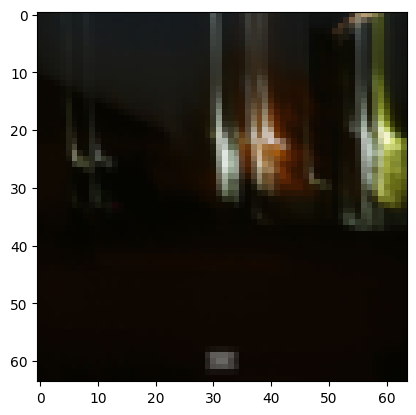

In [58]:
visualize_data(X_train_orig, Y_train_orig)

## preprocess data

In [59]:
## CATVSNONCAT DATASET ##
#########################
def preprocess_data(X, Y = None):
    """Preprocess input data, in order to be fed as the input of the neural network.
    
    Operations:
        - Reshaping of the arrays to fit the Neural Network Input
        - Normalization
    Returns:
        (X_pp, Y_pp)
        
        using the following notations:
        - n_x: number of features in the input of the neural network
        - m: number of observations 
        X_pp: normalized matrix of size (n_x, m)
        Y_pp: normalized array of size (1, m)
    """
    m = X.shape[0]

    ## Reshape the arrays
    ### START CODE ###
    X = X.reshape(m, -1).T
    if Y is not None:
        Y = Y.reshape(m, 1).T
    ### END CODE ###

    ## normalization
    ### START CODE ###
    X = X / 255.
    ### END CODE ###
    return X,Y

####################
####################

In [60]:
# ## FLOWER DATASET ## 
# ####################
# def preprocess_data(X, Y = None):
#     """Preprocess input data, in order to be fed as the input of the neural network.
#     """
#     # nothing to do, the data is already in the right shape and scale !
#     return X, Y
# ###################
# ###################

In [61]:
X_train, Y_train = preprocess_data(X_train_orig, Y_train_orig)
X_test, Y_test = preprocess_data(X_test_orig, Y_test_orig)

print(f"X_train shape: {X_train.shape}")
print(f"Y_train shape: {Y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"Y_test shape: {Y_test.shape}")

X_train shape: (12288, 209)
Y_train shape: (1, 209)
X_test shape: (12288, 50)
Y_test shape: (1, 50)


## define the network structure

We want to build a logistic regression, which can be seen as the following 1-layer neural network:

![](../../schemas/schema-LR.png)

In [62]:
def get_layer_sizes(X):
    """
    Returns the size of each neural network layer.
    
    (n_0, n_1)
    """
    ### START CODE ###
    n_0 = X.shape[0]
    n_1 = 1
    
    ### END CODE ###
    return (n_0, n_1)



In [63]:
n_0, n_1 = get_layer_sizes(X_train)
print(f"n_0: {n_0}")
print(f"n_1: {n_1}")

n_0: 12288
n_1: 1


## initialize the parameters

In [64]:
def initialize_params(n_0: int, n_1: int):
    """Initialize the logistic regression parameters.
    
    Args:
        - n_0: the number of neurons for the input layer
        - n_1: the number of neurons of the output layer
    
    Returns:
        - params: a dictionary of the model parameters: {"W": W, "b": b}
    """
    W = np.zeros((n_1, n_0))
    b = np.zeros(n_1)
    
    params = {
            "W": W,
            "b": b
        }
        
    return params

In [65]:
params = initialize_params(n_0, n_1)

In [66]:
params["W"].shape

(1, 12288)

## forward propagate

In [67]:
def forward_propagate(params, X):
    """Perform the forward propagation operation.
    
    Args:
        - params: a dictionary of the model parameters: {"W": W, "b": b}
        - X: a dataset of observation (shape: n_0, m)

    Returns:
        - A: the matrix of activations of the output layer
    """
    ### START CODE ###
    W = params["W"]
    b = params["b"]
    A = sigmoid(np.dot(W, X) + b)
    ### END CODE ###
    
    return A

In [68]:
A = forward_propagate(params, X_train)

## compute the cost

In [69]:
def compute_cost(A, Y):
    """Compute the cost of the output layer activation.
    
    Args:
        - A: the matrix of activations of the output layer. Shape: (n_1,m)
        - Y: ground truths. Shape: (n_1,m)
    """
    ### START CODE ###
    m = A.shape[1]
    cost = -(1/m)*np.sum(Y*np.log(A) + (1-Y)*np.log(1-A))
    ### END CODE ###
    
    return cost

In [70]:
compute_cost(A, Y_train)

0.6931471805599453

## backward propagate

In [71]:
def backward_propagate(X, Y, A):
    """The Backward propagation operation.
    
    Args:
        - X: the matrix of observations. Shape: (n_0, m)
        - Y: ground truths. Shape: (n_1, m)
        - A: the activations of the output layer. Shape: (n_1, m)
    
    Returns:
        - grads: a dictionary containing the gradients for all model parameters. {"dW": dW, "db": db}
    """
    ### START CODE ###
    m = X.shape[1]
    grads = dict()
    grads["dW"] = (1/m) * np.dot((A-Y), X.T)
    grads["db"] = (1/m) * np.sum(A-Y)
    ### END CODE ###
    
    return grads

In [72]:
grads = backward_propagate(X_train, Y_train, A)

In [73]:
grads["dW"].shape

(1, 12288)

## update the parameters

In [74]:
def update_params(params, grads, learning_rate):
    """Update weights using gradient descent.
    
    Args:
        - params: a dictionary of the model parameters: {"W": W, "b": b}
        - grads: a dictionary containing the gradients for all model parameters. {"dW": dW, "db": db}
        - learning_rate: the learning rate (float number)
    Returns:
        - params: a dictionary of the model parameters updated: {"W": W, "b": b}
    """
    ### START CODE ###
    W = params["W"]
    b = params["b"]
    dW = grads["dW"]
    db = grads["db"]

    W = W - learning_rate*dW
    b = b - learning_rate*db

    params["W"] = W
    params["b"] = b
    ### START CODE ###
    
    return params

In [75]:
params = update_params(params, grads, 0.01)

## train

In [76]:
def train(X, Y, nb_iterations, learning_rate):
    """Combines all the operations necessary to train the logistic regression.
    
    Args:
        - X: the matrix of observations. Shape: (n_0, m)
        - Y: ground truths. Shape: (n_1, m)
        - nb_iterations: number of iterations to perform gradient descent
        - learning_rate: the learning rate (float number)

    Returns:
        - (params, cost) with:
            - params: dictionary of the model parameters: {"W": W, "b": b}
            - costs: list of the costs for each 100th iteration (iteration 1, iteration 100, etc.)
    """
    
    ### START CODE ###
    m = X.shape[1]
    n_x, n_y = get_layer_sizes(X)
    params = initialize_params(n_x, n_y)

    costs = list()

    for i in range(nb_iterations):
        A = forward_propagate(params, X)
        cost = compute_cost(A, Y)
        grads = backward_propagate(X, Y, A)
        params = update_params(params, grads, learning_rate)

        if (i % 100) == 0:# we store the cost each 100 iterations
            costs.append(cost)
    ### START CODE ###
    
    return params, costs

In [77]:
nb_it = 2000
learning_rate = 0.01
params, costs = train(X_train, Y_train, nb_it, learning_rate)

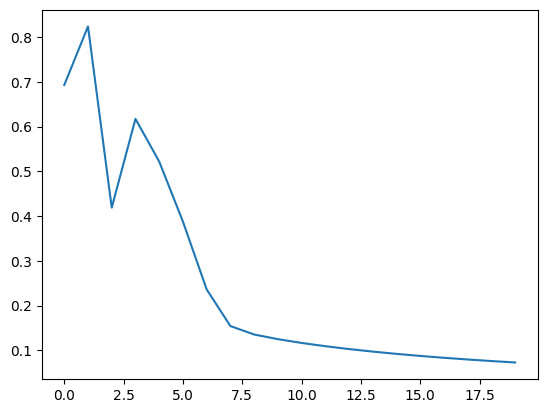

In [78]:
plt.plot(costs)

## predict

In [79]:
def predict(params, X, threshold = 0.5):
    """Predicts the output of the logistic regression.

    Args:
        - params: dictionary of the model parameters: {"W": W, "b": b}
        - X: a matrix of observations. Shape: (n_0, ?)
        - threshold: threshold to use for the prediction (default 0.5 means: if p >= 0.5, we predict 1, else 0)
    
    Returns:
        - Yp: vector of predictions.
    """
    ### START CODE ###
    A = forward_propagate(params, X)
    Yp = 1*(A >= threshold)
    ### START CODE ###

    return Yp

In [80]:
predict(params, X_train)

array([[0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0,
        0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0,
        0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0,
        0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0,
        1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1,
        1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0,
        0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1,
        0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1,
        0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1,
        0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]])

## evaluate the performance

In [81]:
def evaluate_performance(X_train, Y_train, X_test, Y_test, params, print_perf=True):
    """Evaluates the performance of the logistic regression.
    
    Args:
        - X_train: matrix of observations for the training set
        - Y_train: ground truths for the training set
        - X_test: matrix of observations for the test set
        - Y_test: ground truths for the test set
        - params: the logistic regression parameters
        - print_perf: boolean. If true, prints the performance on the train and test set, as well as the baseline performance.

    Returns:
        - (acc_train, acc_test) where:
            - acc_train: accuracy on the train set
            - acc_test: accuracy on the test set
    """
    ### START CODE ###
    Yp_train = predict(params, X_train)
    Yp_test = predict(params, X_test)
    
    acc_train = np.mean(Yp_train == Y_train)
    acc_test = np.mean(Yp_test == Y_test)

    if print_perf:
        print(f'train accuracy: {acc_train:.1%}')
        print(f'test accuracy: {acc_test:.1%}')
        print("")
        
        acc_bs_one = (Y_test == 1).mean()
        acc_bs_zero = (Y_test == 0).mean()
        print('baseline:')
        print(f'test accuracy, model always predicts "1": {acc_bs_one:.1%}')
        print(f'test accuracy, model always predicts "0": {acc_bs_zero:.1%}')
    ### START CODE ###

    
    return acc_train, acc_test

In [82]:
evaluate_performance(X_train, Y_train, X_test, Y_test, params)

train accuracy: 99.5%
test accuracy: 70.0%

baseline:
test accuracy, model always predicts "1": 66.0%
test accuracy, model always predicts "0": 34.0%


(0.9952153110047847, 0.7)

## predict on a custom image

Now that you have trained the logistic regression, it's important to know how to load a custom image and predict on it.

**Note**: you have nothing to code in this section. Just run the code, and understand it !

In [83]:
from PIL import Image

#path_img = Path("../../data/catvnoncat/cat_11.jpeg")
path_img = Path("../../data/catvnoncat/Cat_March_2010-1.jpeg")

In [84]:
def load_and_resize_image(path_img, target_size = (64,64)):
    img = Image.open(path_img)
    img = img.resize(target_size)
    X_img = np.array(img)
    X_img = np.expand_dims(X_img, axis=0)
    return X_img

In [85]:
X_img = load_and_resize_image(path_img)

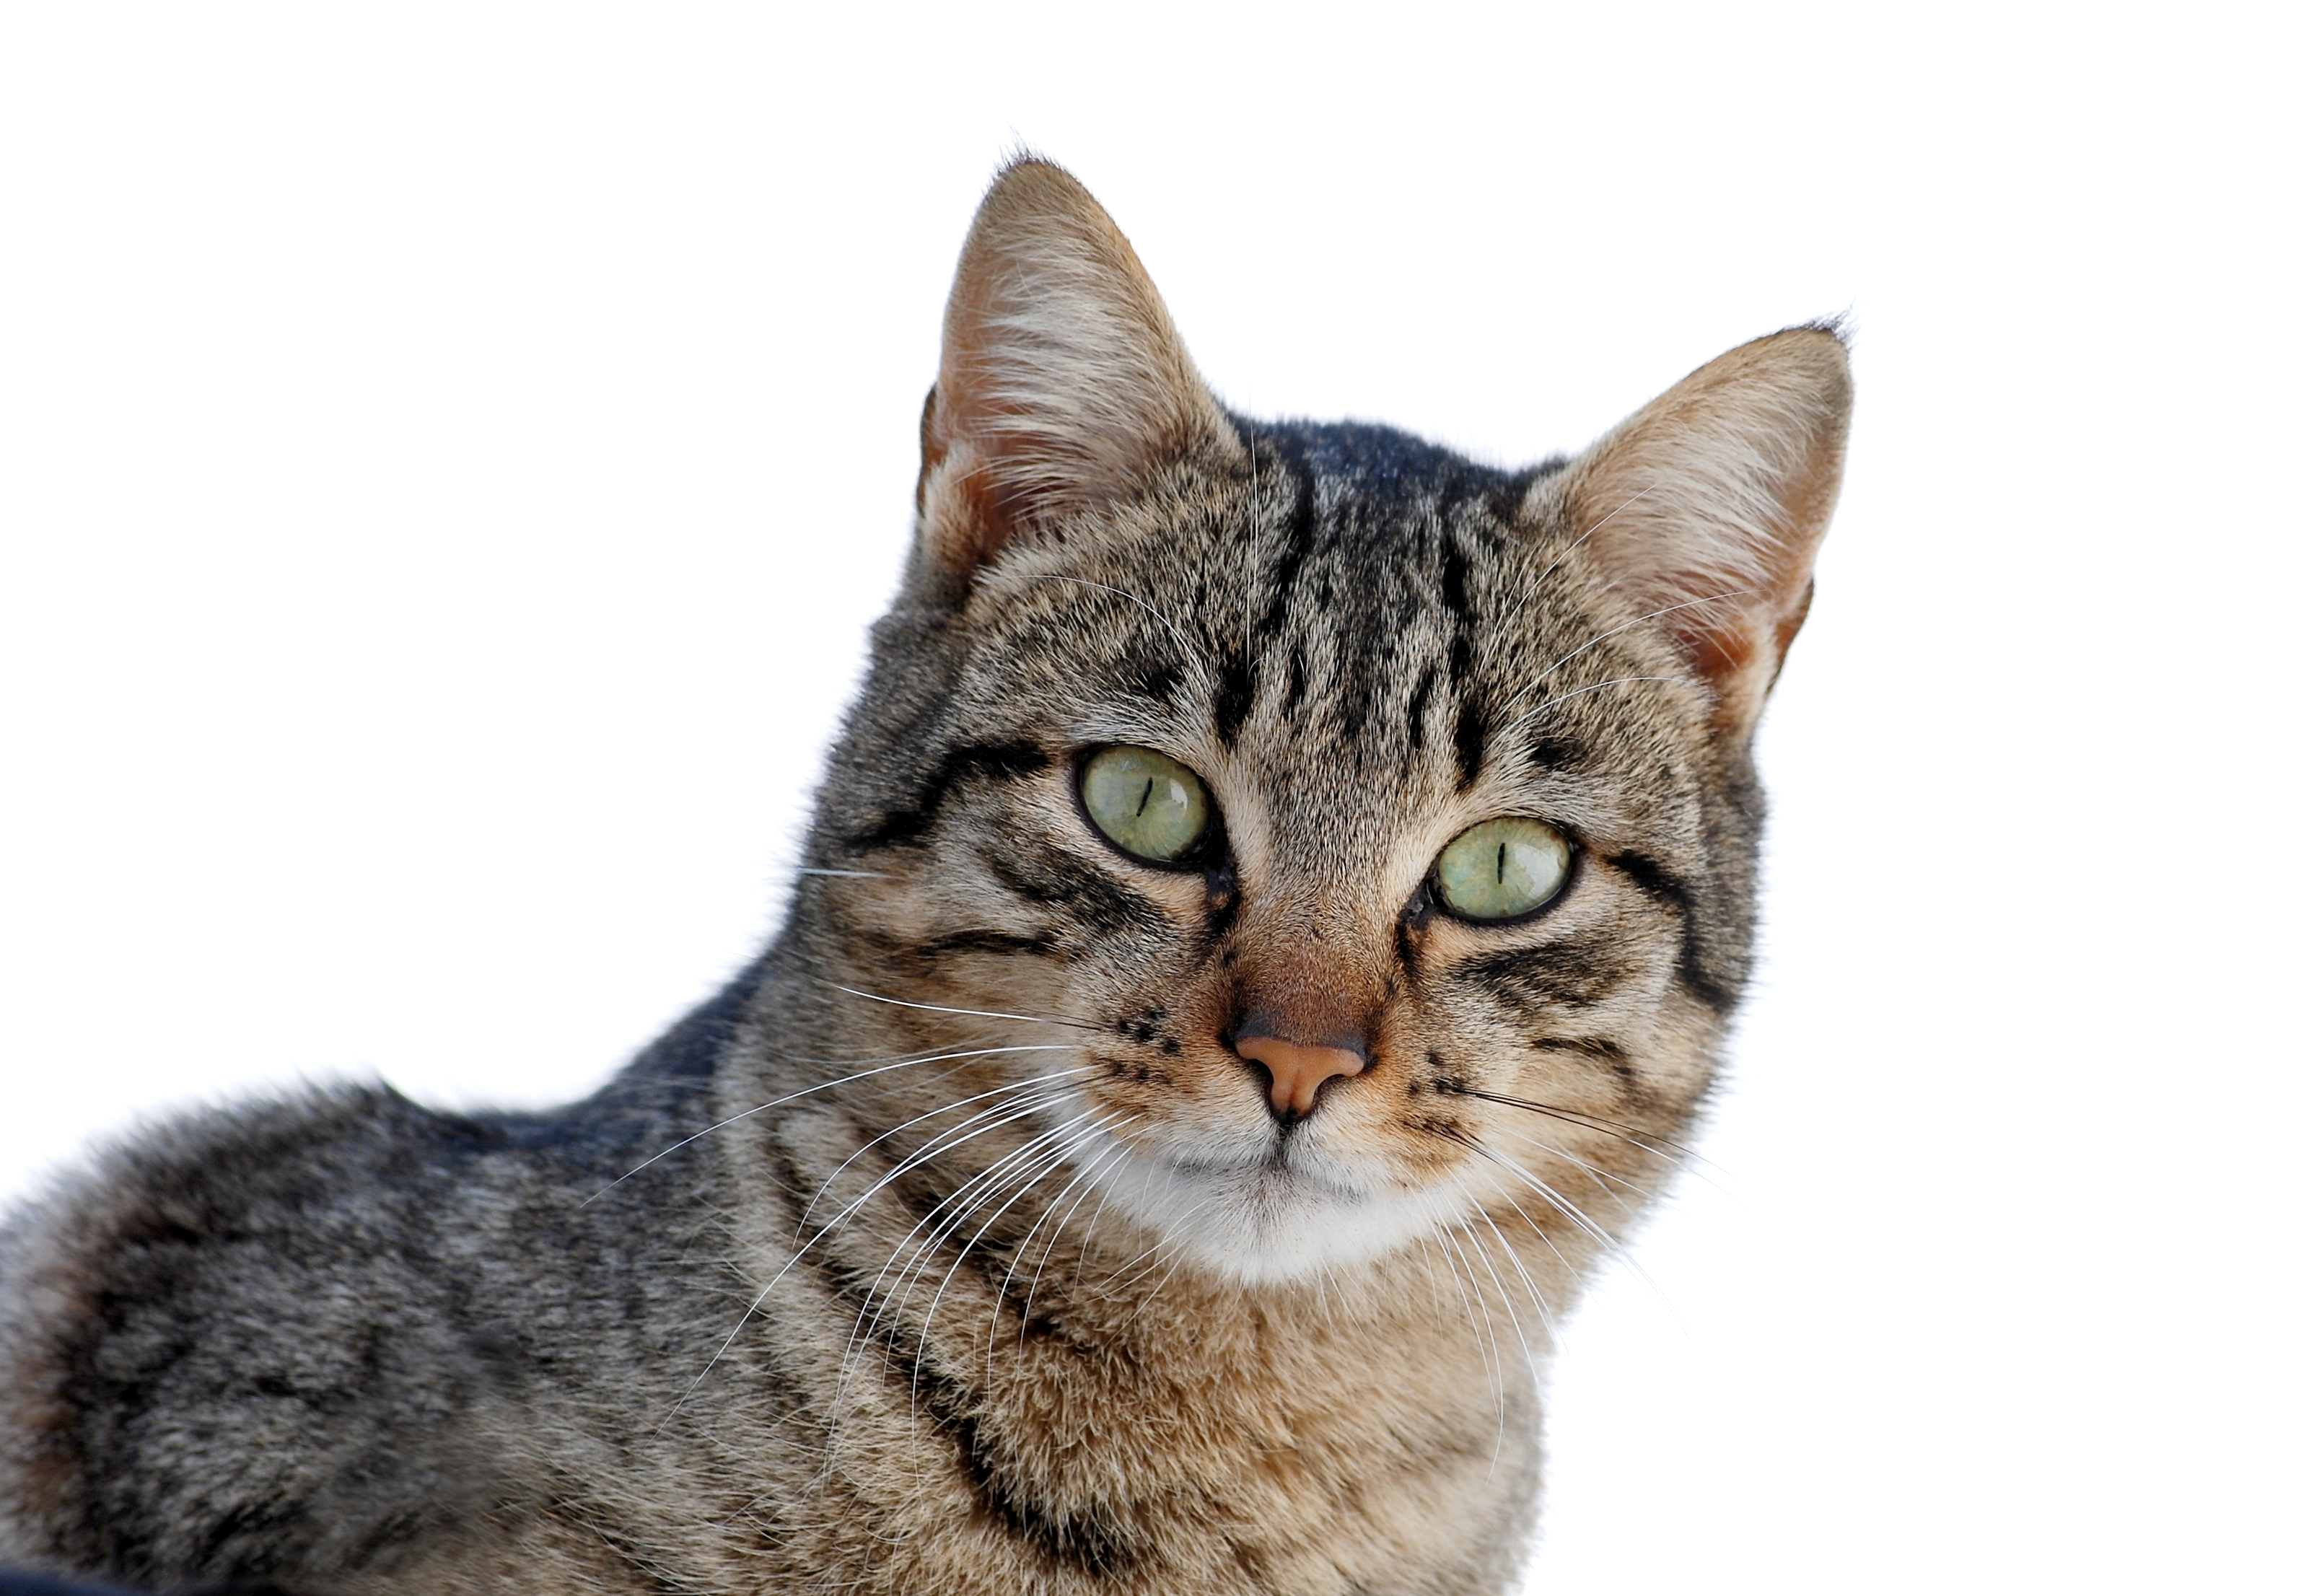

In [86]:
## image originelle
img = Image.open(path_img)
img

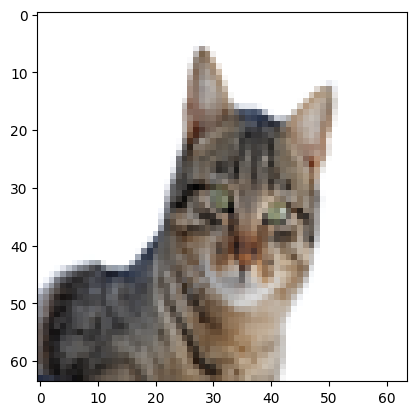

In [87]:
## image après resizing
plt.imshow(X_img[0])

In [88]:
X_img, _ = preprocess_data(X_img)

In [89]:
predict(params, X_img)

array([[1]])

# EXPERIMENTS

Nothing to code in this section, you can run the code directly and experiment with different values of the hyperparameters

## experiment with the learning rate

In [90]:
def experiment_with_learning_rate(X_train, Y_train, X_test, Y_test, learning_rates, nb_iterations=2000):
    """Experiments training the logistic regression with different learning rates.
    
    Args:
        - X_train: matrix of observations for the train set
        - Y_train: ground truths for the train set
        - X_test: matrix of observations for the test set
        - Y_test: ground truths for the test set
        - learning_rates: list of learning rates to test
        - nb_iterations: number of iterations to train the logistic regression

    Displays:
        - the graph "cost = f(nb iterations)" for each learning rate
        - the train and test set accuracy for each learning rate

    Returns:
        - None
    """
    res_cost = dict()
    res_acc = dict() 

    for lr in learning_rates:
        params, costs = train(X_train, Y_train, nb_iterations, lr)
        acc_train, acc_test = evaluate_performance(X_train, Y_train, X_test, Y_test, params, print_perf=False)

        res_cost[lr] = costs
        res_acc[lr] = (acc_train, acc_test)
        
        plt.plot(res_cost[lr], label= lr)
    
    ## display the evolution of the cost
    plt.xlabel = "iteration ( % 100)"
    plt.ylabel = "cost"
    plt.legend(loc='upper center', shadow=True)
    plt.show()

    ## display the accuracy
    for lr in learning_rates:
        print(f'LR = {lr} / train accuracy = {res_acc[lr][0]:.1%}, test accuracy = {res_acc[lr][1]:.1%}')


/var/folders/zj/d2z7y8092qq392r17r_m2s100000gn/T/ipykernel_4150/213240829.py:10: RuntimeWarning: divide by zero encountered in log
  cost = -(1/m)*np.sum(Y*np.log(A) + (1-Y)*np.log(1-A))
/var/folders/zj/d2z7y8092qq392r17r_m2s100000gn/T/ipykernel_4150/213240829.py:10: RuntimeWarning: invalid value encountered in multiply
  cost = -(1/m)*np.sum(Y*np.log(A) + (1-Y)*np.log(1-A))


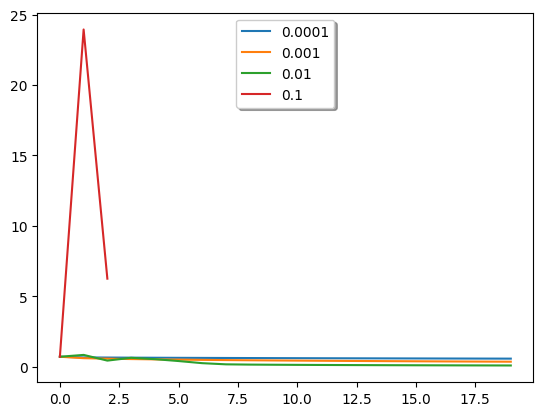

LR = 0.0001 / train accuracy = 71.3%, test accuracy = 40.0%
LR = 0.001 / train accuracy = 91.4%, test accuracy = 68.0%
LR = 0.01 / train accuracy = 99.5%, test accuracy = 70.0%
LR = 0.1 / train accuracy = 100.0%, test accuracy = 66.0%


In [91]:
learning_rates = [10**-4, 10**-3, 10**-2, 10**-1]
experiment_with_learning_rate(X_train, Y_train, X_test, Y_test, learning_rates)